# Development notebook for a better disk integration implementation

This notebook is used for the development of a faster way to perform disk integration, based on discussions with Oleg Kochukhov and based on the python ZDI implementation of Colin Folsom. 

## 0. Importing packages

In [1]:
import pyRaven as rav
import numpy as np
import matplotlib.pyplot as plt
import time

## 1. Setting up a framwork to develop the new procedure, by following the structure of the numerical function in diskint2. 

In [2]:
# Getting a set of default parameters
param = rav.params.get_def_param_weak()
param['general']['vmac'] = 0.0
param['general']['phase'] = 36.0
param['general']['incl'] = 12.0
param['general']['beta'] = 23.0
param.pprint()

{
  "general": {
    "lambda0": 5000,
    "vsini": 50.0,
    "vdop": 10.0,
    "av": 0.05,
    "bnu": 1.5,
    "logkappa": 0.98,
    "ndop": 10,
    "Bpole": 1000,
    "incl": 12.0,
    "beta": 23.0,
    "phase": 36.0,
    "vmac": 0.0
  },
  "weak": {
    "geff": 1.0
  }
}


The cell below is setting up the grid, make the LOS calculations, and the Bz calculations. This is exactly in the same form as diskint2.numerical for the weak-field and the loop code

In [3]:
unno = False
verbose = False 

uconv = rav.diskint2.get_uconv(param)
ngrid = rav.diskint2.get_ngrid(param['general']['vsini'], verbose=verbose)
ngrid = 5000
kappa = 10**param['general']['logkappa']    

perGaussLorentz = rav.diskint2.get_perGaussLorentz(param['general']['lambda0'], param['general']['vdop'])

sig = 10 # the width of the Voigt profile. 10 sigma is usually enough
small_u = rav.diskint2.get_small_u(sig, param['general']['ndop'])

w_weak, dw_weak = rav.diskint2.get_w_weak(small_u, param['general']['av'], param['general']['ndop'])
# Figure out the length of vector that we need for the velocity grid.
vel_range = param['general']['vsini']/param['general']['vdop']+sig

all_u = rav.diskint2.get_all_u(vel_range, param['general']['ndop'], verbose=verbose)

model = rav.diskint2.get_empty_model(all_u, 
                            param['general']['vdop'], param['general']['lambda0'],
                            unno=unno)

ROT, A = rav.diskint2.grid_ROT(ngrid) 
los2rot = rav.diskint2.get_los2rot(param['general']['incl'], param['general']['phase'])
rot2los = np.transpose(los2rot)
LOS = rav.diskint2.get_LOS(ROT, rot2los)
mu_LOS, vis, A_LOS, uLOS, conti_flux = rav.diskint2.get_LOS_values(LOS, A, param['general']['bnu'], param['general']['vsini'], param['general']['vdop'])
rot2mag = rav.diskint2.get_rot2mag(param['general']['beta']) 
mag2rot = np.transpose(rot2mag)
MAG = rav.diskint2.get_MAG(ROT, rot2mag)
B_MAG = rav.diskint2.get_B_MAG(MAG)
B_LOS = rav.diskint2.get_B_LOS(B_MAG, mag2rot, rot2los)


## 2. New disk integration

In the cell below, I tested two different methods to broadcast the arrays into a tile, to see which one is the fastest. 

In [4]:
# Testing tile versus broadcast for efficiency
nvis = vis[vis].size

import inspect
import timeit

code_block = inspect.cleandoc("""
    u_matrix = np.tile(all_u, (nvis,1)) - np.tile(uLOS[vis], (all_u.size,1)).T
    """)
print(f'\Code block: {timeit.timeit(code_block, number=100, globals=globals())} elapsed seconds')

code_block = inspect.cleandoc("""
u_matrix = np.broadcast_to(all_u, (nvis, all_u.size)) - np.broadcast_to(uLOS[vis], (all_u.size,nvis)).T
    """)
print(f'\Code block: {timeit.timeit(code_block, number=100, globals=globals())} elapsed seconds')

code_block = inspect.cleandoc("""
u_matrix = np.ones((nvis, all_u.size))*all_u[np.newaxis,:] - uLOS[vis][:,np.newaxis]
    """)
print(f'\Code block: {timeit.timeit(code_block, number=100, globals=globals())} elapsed seconds')


\Code block: 0.12919974999999972 elapsed seconds
\Code block: 0.05367862499999987 elapsed seconds
\Code block: 0.10990725000000001 elapsed seconds


All of these methods are similar (if I run the cell above a few times, I get some variations about which one is the best, but all in the same range.. but the tile method is consistently above the other two)

In the cell below, I wrote down the method, along with some graphical tests (because at first I forgot a sqrt(pi) factor :facepalm). 

All looks good. 

0.0193784236907959


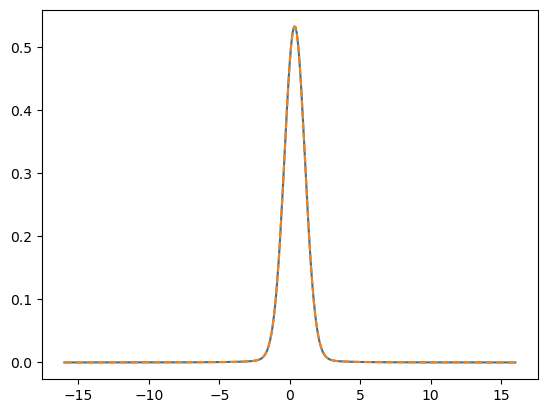

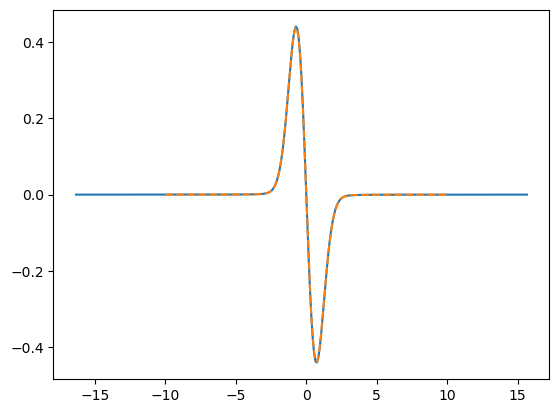

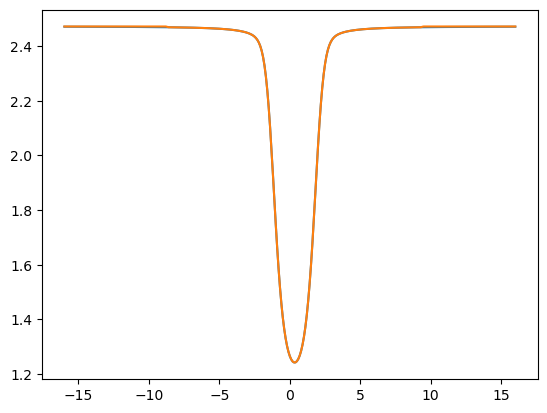

In [5]:
a = param['general']['av']
bnu = param['general']['bnu']

tic = time.time()

nvis = vis[vis].size

u_matrix = np.broadcast_to(all_u, (nvis, all_u.size)) - np.broadcast_to(uLOS[vis], (all_u.size,nvis)).T

# Replacing the code below by a function in profileI
'''
t = a -1j*u_matrix

voigt_mat = np.empty(u_matrix.shape, dtype=complex)

# Voigt region 1
n = (np.abs(u_matrix)+a) >= 15.0
voigt_mat[n] = 0.5641896*t[n]/(0.5 + t[n]**2)

# Voigt region 2
n = np.logical_and( (np.abs(u_matrix)+a) < 15.0, (np.abs(u_matrix)+a) > 5.5 )
voigt_mat[n] = t[n]*(1.410474 + 0.5641896*t[n]**2)/((3.0 + t[n]**2)*t[n]**2 + 0.75)

# Voigt region 3
n = np.logical_and( (np.abs(u_matrix)+a) < 5.5, (u_matrix + 1j*a).imag >= (0.195*abs((u_matrix + 1j*a).real) - 0.176) )
voigt_mat[n] = (16.4955 + t[n]*(20.20933 + t[n]*(11.96482 + t[n]*(3.778987 + t[n]*0.5642236))))/ (16.4955 + t[n]*(38.82363 + t[n]*(39.27121 + t[n]*(21.69274 + t[n]*(6.699398 + t[n])))))

# Voigt region 4
n = np.logical_and( (np.abs(u_matrix)+a) < 5.5, (u_matrix + 1j*a).imag < (0.195*abs((u_matrix + 1j*a).real) - 0.176) )
voigt_mat[n] = np.exp(t[n]**2) - t[n]*(36183.31 - t[n]**2* (3321.9905 - t[n]**2* (1540.787 - t[n]**2*(219.0313 - t[n]**2* (35.76683 - t[n]**2* (1.320522 - t[n]**2*0.56419))))))/ (32066.6 - t[n]**2* (24322.84 - t[n]**2*(9022.228 - t[n]**2* (2186.181 - t[n]**2* (364.2191 - t[n]**2*(61.57037 - t[n]**2* (1.841439 - t[n]**2)))))))
'''
voigt_mat, dvoigt_mat = rav.profileI.get_voigt_weak(u_matrix, param['general']['av'])

# now included in the function called above.
'''
voigt_mat = voigt_mat/np.sqrt(np.pi)
'''

##########
##########
## checking the voigt
i = 10 # i-th element in vis...
fig, ax = plt.subplots(1,1)
# checking that the voigt calculations itself is ok, with the same u-array
#ax.plot(u_matrix[i,:], voigt_mat[i,:].real)
#ax.plot(u_matrix[i,:], rav.profileI.voigt_fara(u_matrix[i,:],a).real, ls='--')
# now checking the interpolation result...
ax.plot(all_u, voigt_mat[i,:].real)
ax.plot( all_u, rav.localV.interpol_lin(w_weak,  small_u+uLOS[vis][i], all_u), ls='--')

##########

# Now included in the get_voigt_weak function
'''
#From Landi & Landofi 2005, eq 5.58
#dHdv = (2.*(-v*w4.real + anm*w4.imag))
dvoigt_mat = 2*(-1*u_matrix*voigt_mat.real + a*voigt_mat.imag)
voigt_mat = voigt_mat.real
'''

##########
##########
## checking the derivative
i = 10 # i-th element in vis...
fig, ax = plt.subplots(1,1)
ax.plot(u_matrix[i,:], dvoigt_mat[i,:])
ax.plot(small_u, dw_weak, ls='--')
##########

mu_LOS_mat = np.broadcast_to(mu_LOS[vis], (all_u.size,nvis)).T
Bz_mat = np.broadcast_to(B_LOS[2,vis], (all_u.size,nvis)).T
A_LOS_mat = np.broadcast_to(A_LOS[vis], (all_u.size,nvis)).T

local_I_mat = 1 + mu_LOS_mat*bnu / (1+kappa*voigt_mat)
local_V_mat = Bz_mat * ( mu_LOS_mat * dvoigt_mat/(1+kappa*voigt_mat)**2 )
local_V_mat = local_V_mat * param['weak']['geff'] * param['general']['Bpole']/2.0 * perGaussLorentz * bnu*kappa

##########
## checking the local profile...
i = 10 # i-th element in vis...
fig, ax = plt.subplots(1,1)
ax.plot(all_u, local_I_mat[i,:])
testI, testV = rav.diskint2.get_local_weak_interp(small_u, w_weak, dw_weak, all_u,
                                    uLOS[vis][i], mu_LOS[vis][i], 
                                    bnu, kappa, 
                                    B_LOS[2,vis][i]  )
ax.plot(all_u, testI)
#print(mu_LOS[vis][i], mu_LOS_mat[i,0])
##########

flux = np.sum(A_LOS_mat*local_I_mat, axis=0) / conti_flux
V = np.sum(A_LOS_mat*local_V_mat, axis=0) / conti_flux

toc = time.time()

## Only need to do this calculation 
print((toc-tic)*18*18*2/3600)

#fig, ax = plt.subplots(1,1)
#p = ax.imshow(u_matrix, cmap='seismic')
#p = ax.imshow(voigt_mat.real, cmap='seismic')
#fig.colorbar(p)
#for i in range(0,nvis):
#    ax.plot(all_u, voigt_mat[i,:].real)
#ax.plot(all_u, flux)

## 3. Benchmarking the loop disk integration

In [6]:
tic = time.time()
for i in range(0,vis[vis].size):
    local_I, local_V = rav.diskint2.get_local_weak_interp(small_u, w_weak, dw_weak, all_u,
                                    uLOS[vis][i], mu_LOS[vis][i], 
                                    param['general']['bnu'], kappa, 
                                    B_LOS[2,vis][i]  )

    # numerical integration (hence the projected area multiplication)
    model['flux'] += A_LOS[vis][i]*local_I
    model['V'] += A_LOS[vis][i]*local_V
# constant stuff that I pulled out of the loop in get_local_weak_interp 
model['V'] = model['V'] * param['weak']['geff'] * param['general']['Bpole']/2.0 * perGaussLorentz * param['general']['bnu']*kappa
model['flux'] /= conti_flux
model['V'] /= conti_flux

toc = time.time()
print((toc-tic)*25*18*18*18*2/3600)

17.704497814178467


## 4. Comparison

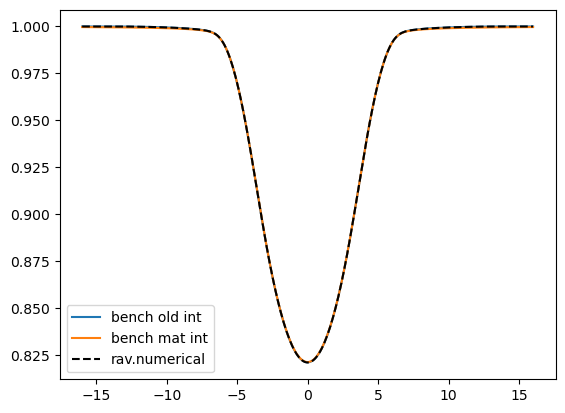

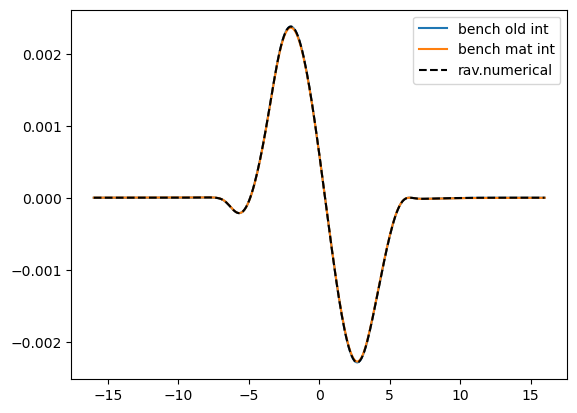

In [7]:
model2 = rav.diskint2.numerical(param, unno=False)

fig, ax = plt.subplots(1,1)
ax.plot(model['uo'], model['flux'], label='bench old int')
ax.plot(all_u, flux, label='bench mat int')
ax.plot(model2['uo'], model2['flux'], c='k', ls='--', label='rav.numerical')
ax.legend(loc=0)


#ax.plot(models['uo'], models['flux'], ls='--')

fig, ax = plt.subplots(1,1)
ax.plot(model['uo'], model['V'], label='bench old int')
ax.plot(all_u, V, label='bench mat int')
ax.plot(model2['uo'], model2['V'], c='k', ls='--', label='rav.numerical')
ax.legend(loc=0)

## 5. Testing the loop codes

The cell below tests the loop code by plotting the model computed inside the loop with the standalone computation. 

Note, for this to output a plot from inside the loop, the testing block of codes needs to be uncommented in the loop2 code. 

Using 9000.0 grid point on the surface
Max velocity needed: 30.0 vdop
Number of wavelength/velocity grid points: 621
Starting inclination loop 0/1
0.31732916831970215


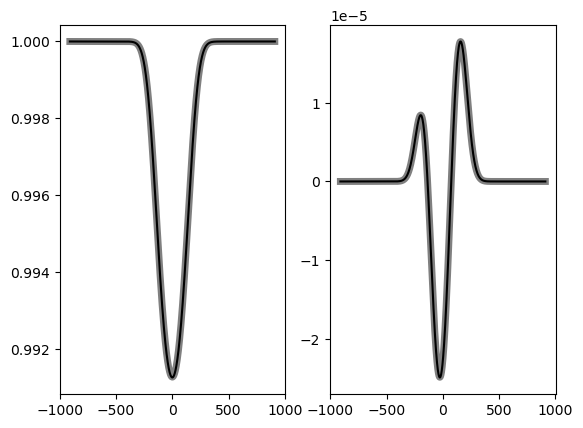

In [4]:
genparam = {
    'lambda0':5000,    # the central wavelength of the transition
    'vsini':200.0,         # the projected rotational velocity
    'vdop':10.0,          # the thermal broadening
    'av':0.05,             # the damping coefficient of the Voigt profile
    'bnu':1.5,             # the slope of the source function with respect to vertical optical depth
    'logkappa':-0.20,          # the line strength parameter
    'ndop':int(10),       # the number of sample point per doppler width for the wavelength array
    'res':65000,
    'vmac':60,
    'Bpole':1000,
    'incl':30.0,
    'beta':260.0,
    'phase':57.0
  }

weakparam = {
        'geff':1.0
    }

gridparam = {
        'Bpole_grid': np.array([genparam['Bpole']]),
        'incl_grid': np.array([genparam['incl']]),
        'beta_grid': np.array([genparam['beta']]),
        'phase_grid': np.array([genparam['phase']])
        }
    
param={'general' : genparam,
       'weak' : weakparam,
       'grid' : gridparam
       }

Packet = rav.data.read_packet('../HowToUsePyRavenTutorial/ExampleData/ExamplePacket.h5')
model = rav.diskint2.numerical(param)

fig, ax = plt.subplots(1,2)
ax[0].plot(model['vel'], model['flux'], lw=5, c='0.5')
ax[1].plot(model['vel'], model['V'], lw=5, c='0.5')

rav.loop_speed2.loop_speed2(param, Packet, path='test/', ax=ax)


## Checking the speed

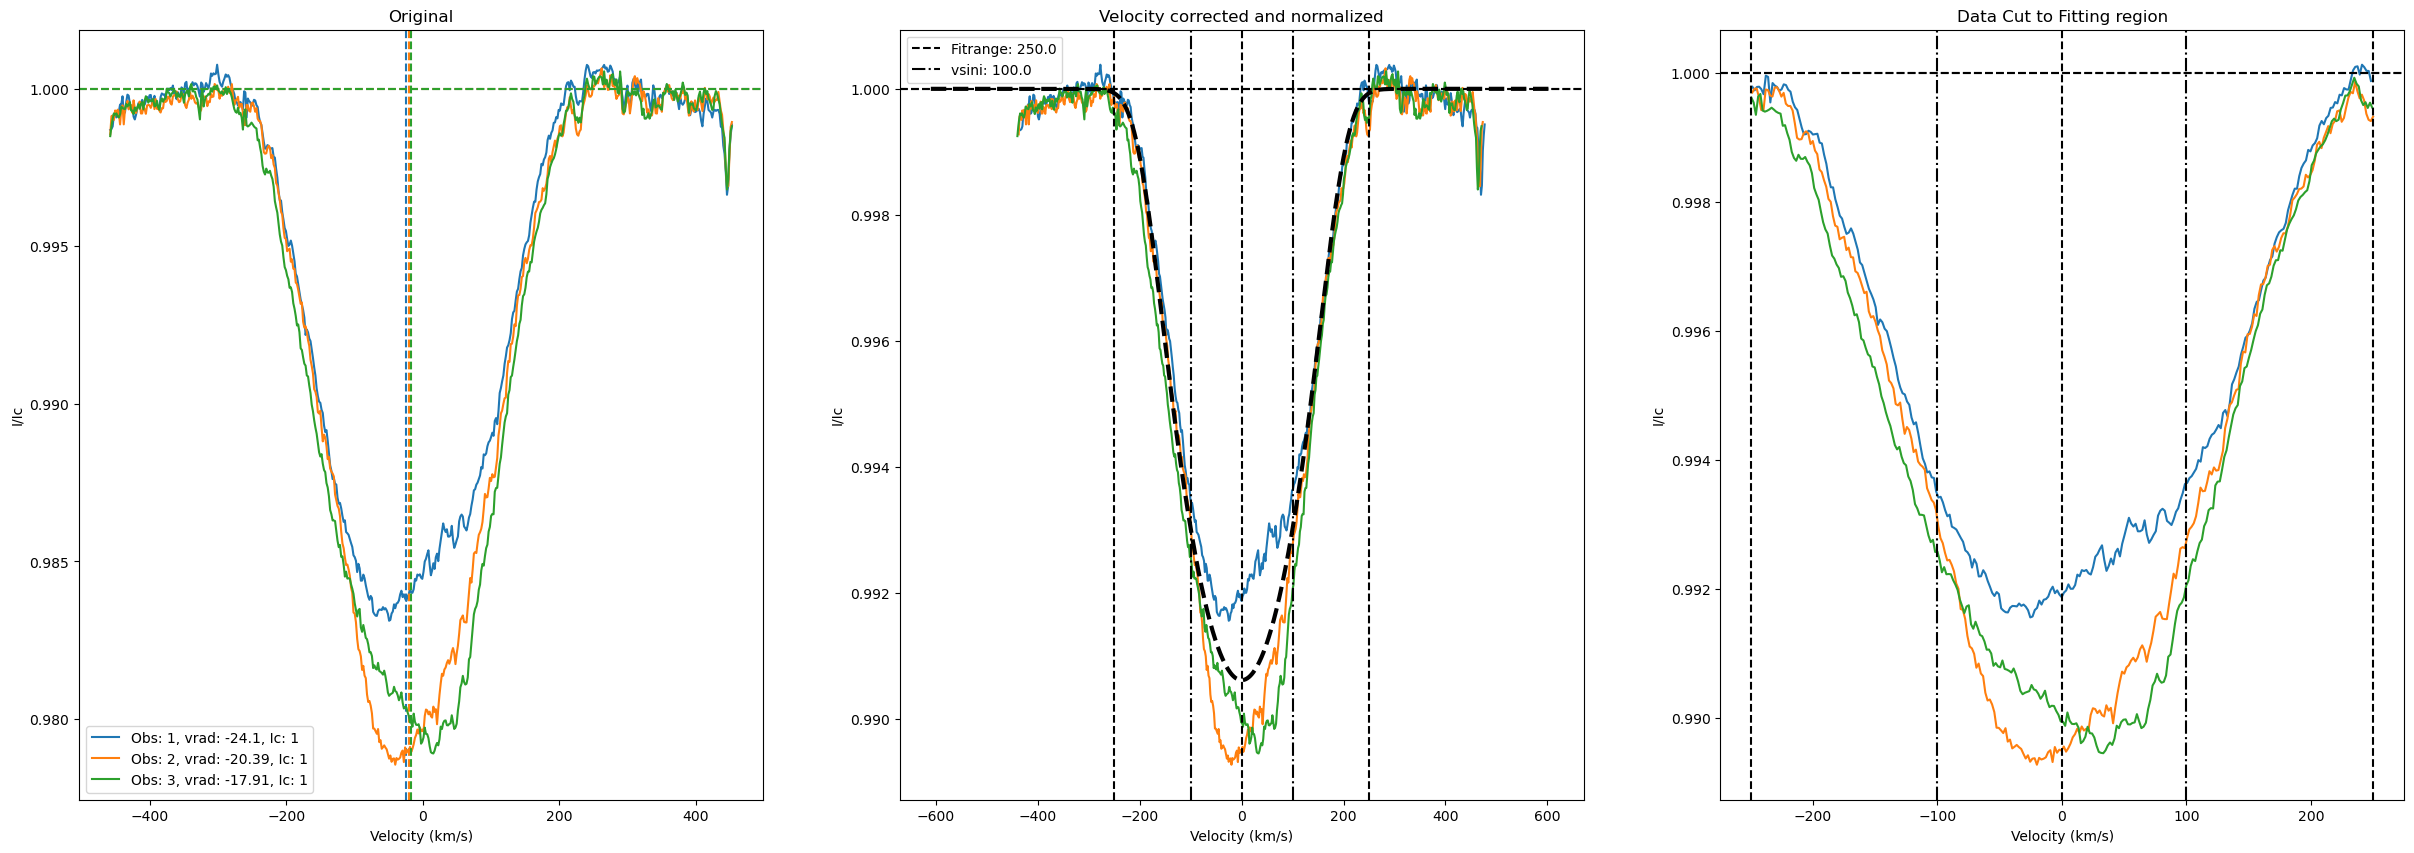

In [4]:
genparam = {
    'lambda0':5000,    # the central wavelength of the transition
    'vsini':200.0,         # the projected rotational velocity
    'vdop':10.0,          # the thermal broadening
    'av':0.05,             # the damping coefficient of the Voigt profile
    'bnu':1.5,             # the slope of the source function with respect to vertical optical depth
    'logkappa':-0.20,          # the line strength parameter
    'ndop':int(10),       # the number of sample point per doppler width for the wavelength array
    'res':65000,
    'vmac':30,
    'Bpole':1000,
    'incl':90.0,
    'beta':90.0,
    'phase':0.0
  }

weakparam = {
        'geff':1.0
    }

gridparam = {
        'Bpole_grid': np.linspace(0,5000,25),
        'incl_grid': np.array([10, 20, 30, 40]),
        'beta_grid': np.linspace(0,180,18),
        'phase_grid': np.linspace(0,360,18*2)
        }
    
param={'general' : genparam,
       'weak' : weakparam,
       'grid' : gridparam
       }

Packet = rav.data.read_packet('../HowToUsePyRavenTutorial/ExampleData/ExamplePacket.h5')
model = rav.diskint2.numerical(param)
fig, ax = Packet.plotI()
ax[1].plot(model['vel'], model['flux'], c='k', ls='--', lw=3)

In [5]:
rav.loop_speed2.loop_speed2(param, Packet, path='test/')

Using 9000.0 grid point on the surface
Max velocity needed: 30.0 vdop
Number of wavelength/velocity grid points: 621
Starting inclination loop 0/4
9.188481092453003
Starting inclination loop 1/4
8.756618976593018
Starting inclination loop 2/4
7.982266187667847
Starting inclination loop 3/4
8.508355855941772


In [5]:
rav.loop_speed.loop_speed(param, Packet, path='test/')

Using 9000.0 grid point on the surface
Max velocity needed: 30.0 vdop
Number of wavelength/velocity grid points: 621
Starting inclination loop 0/1
107.00813412666321
